In [1]:
import numpy as np
import tensorflow as tf

import matplotlib as mpl
# mpl.use('Agg')
from matplotlib import pyplot as plt

learn = tf.contrib.learn

HIDDEN_SIZE = 30 # LSTM中隐藏节点的个数
NUM_LAYERS = 2 # LSTM的层数

TIMESTEPS = 10 # 循环神经网络的截断长度
TRAINING_STEPS = 10000                      # 训练轮数
BATCH_SIZE = 32 # batch大小

TRAINING_EXAMPLES = 10000 # 训练数据个数
TESTING_EXAMPLES = 1000 # 测试数据个数
SAMPLE_GAP = 0.01 # 采样间隔

def generate_data(seq):
    X = []
    Y = []
    
    for i in range(len(seq) - TIMESTEPS - 1):
        X.append([seq[i:i+TIMESTEPS]])
        Y.append([seq[i + TIMESTEPS]])
    return np.array(X, dtype=np.float32), np.array(Y,dtype=np.float32)

# LSTM结构单元
def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(HIDDEN_SIZE)
    return lstm_cell

def lstm_model(X, y):
    # 使用多层lstm结构
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE)
    # 使用多层LSTM，不能用lstm_cell*NUM_LAYERS的方法，会导致LSTM的tensor名字都一样
    cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
    x_ = tf.unstack(X,axis=1)
    # 使用TensorFlow接口将多层LSTM结构连成RNN网络并计算前向传播结果
    output, _ = tf.nn.static_rnn(cell,x_,dtype=tf.float32)
    # 
    output = output[-1]
    # 对LSTM网络的输出再做一层全连接层并计算损失。默认为MSE
    prediction, loss = learn.models.linear_regression(output, y)
    
    # 创建优化器并得到优化步骤。
    train_op = tf.contrib.layers.optimize_loss(
        loss, tf.train.get_global_step(),
        optimizer='Adagrad', learning_rate=0.1)
    return prediction, loss, train_op

# 建立drnn
regressor = learn.SKCompat(learn.Estimator(model_fn=lstm_model, model_dir='model/'))

# 用正弦函数生成训练和测试数据集合。
test_start = TRAINING_EXAMPLES * SAMPLE_GAP
test_end = (TRAINING_EXAMPLES + TESTING_EXAMPLES) * SAMPLE_GAP
train_X, train_y = generate_data(np.sin(np.linspace(0,test_start,TRAINING_EXAMPLES,dtype=np.float32)))
test_X, test_y = generate_data(np.sin(np.linspace(test_start,test_end,TESTING_EXAMPLES,dtype=np.float32)))

tf.reset_default_graph()
# 使用fit函数训练模型
regressor.fit(train_X, train_y,batch_size=BATCH_SIZE,steps=TRAINING_STEPS)
# 使用训练好的模型对测试数据进行预测
predicted = [[pred] for pred in regressor.predict(test_X)]
rmse = np.sqrt((predicted-test_y) ** 2).mean(axis=0)
print('mse is : %f' % rmse[0])

Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_save_checkpoints_secs': 600, '_master': '', '_evaluation_master': '', '_num_ps_replicas': 0, '_environment': 'local', '_model_dir': 'model/', '_session_config': None, '_num_worker_replicas': 0, '_task_id': 0, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_train_distribute': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000021F1FC739B0>, '_save_checkpoints_steps': None, '_device_fn': None, '_keep_checkpoint_max': 5, '_is_chief': True, '_task_type': None, '_save_summary_steps': 100}
Instructions for updating:
Please switch to the Estim

INFO:tensorflow:loss = 1.2154121e-06, step = 23201 (0.166 sec)
INFO:tensorflow:global_step/sec: 753.891
INFO:tensorflow:loss = 1.8583605e-06, step = 23301 (0.133 sec)
INFO:tensorflow:global_step/sec: 737.26
INFO:tensorflow:loss = 1.2151822e-06, step = 23401 (0.135 sec)
INFO:tensorflow:global_step/sec: 630.61
INFO:tensorflow:loss = 1.7518959e-06, step = 23501 (0.160 sec)
INFO:tensorflow:global_step/sec: 604.019
INFO:tensorflow:loss = 1.3482784e-06, step = 23601 (0.167 sec)
INFO:tensorflow:global_step/sec: 566.485
INFO:tensorflow:loss = 1.4035115e-06, step = 23701 (0.177 sec)
INFO:tensorflow:global_step/sec: 716.196
INFO:tensorflow:loss = 1.1681443e-06, step = 23801 (0.138 sec)
INFO:tensorflow:global_step/sec: 726.573
INFO:tensorflow:loss = 1.5558649e-06, step = 23901 (0.140 sec)
INFO:tensorflow:global_step/sec: 664.023
INFO:tensorflow:loss = 1.5452654e-06, step = 24001 (0.149 sec)
INFO:tensorflow:global_step/sec: 802.139
INFO:tensorflow:loss = 1.1499765e-06, step = 24101 (0.127 sec)
INF

<Figure size 640x480 with 1 Axes>

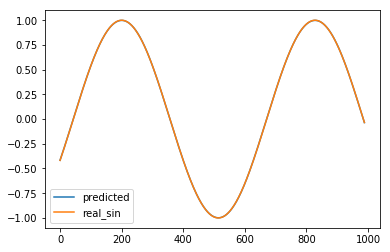

In [2]:
fig = plt.figure()
plot_predicted, = plt.plot(predicted, label='predicted')
plot_test, = plt.plot(test_y, label='real_sin')
plt.legend([plot_predicted, plot_test], ['predicted', 'real_sin'])
plt.show()
# fig.savefig('sin.png')